In [239]:
import sys
sys.path.append("..")
import cv2, requests
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

In [245]:
img = cv2.imread("../data/data_img/psn.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [246]:
def show_pic(img):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img)

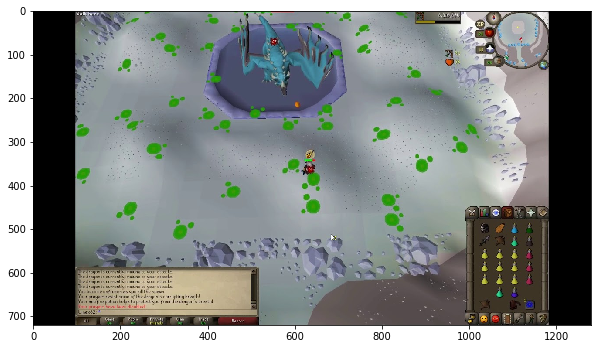

In [247]:
show_pic(img)

In [248]:
green_bound = [[0, 150, 0], [50, 255, 50]]
lower = np.array(green_bound[0], dtype = "uint8")
upper = np.array(green_bound[1], dtype = "uint8")


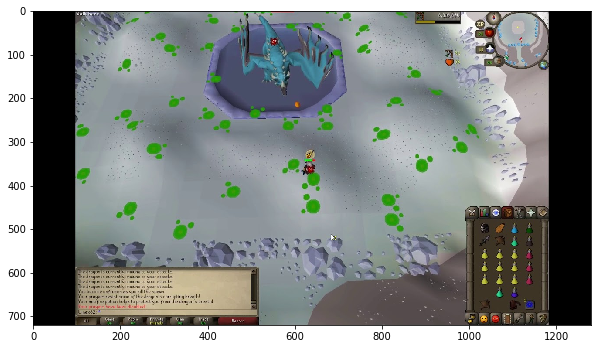

In [249]:
mask = cv2.inRange(img, lower, upper)
masked_img = cv2.bitwise_and(img, img, mask = mask)
show_pic(img)

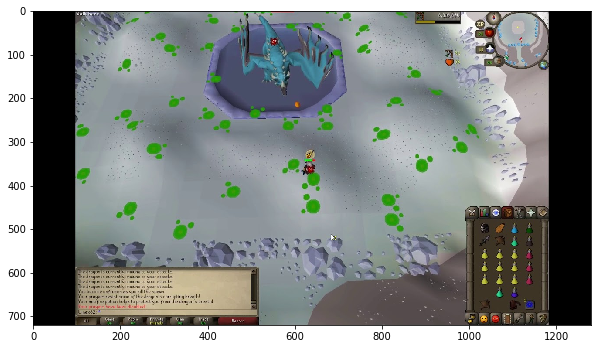

In [250]:
masked_img = cv2.erode(masked_img, None, iterations=2)
masked_img = cv2.dilate(masked_img, None, iterations=4)
show_pic(img)

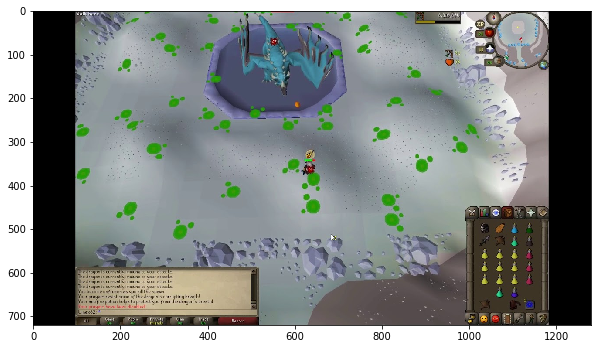

In [251]:
masked_img = cv2.cvtColor(masked_img, cv2.COLOR_RGB2GRAY)
show_pic(img)

In [252]:
contours, hierarchy = cv2.findContours(masked_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [253]:
positions = []
for c in contours:
    if cv2.contourArea(c) <= 50 :
        continue    
    x,y,w,h = cv2.boundingRect(c)
    positions.append((x,y,w,h))
    cv2.rectangle(img, (x, y), (x + w, y + h), (255,0,0), 2)
    cv2.circle(img, (int(x+w/2), int(y+h/2)), 1, (0,0,255), 2) 
    center = (x,y)

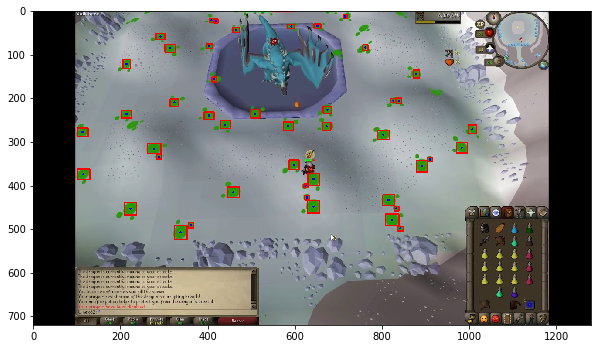

In [254]:
show_pic(img)

In [255]:
positions

[(836, 493, 13, 11),
 (324, 491, 29, 32),
 (356, 485, 12, 12),
 (808, 465, 31, 27),
 (828, 447, 11, 11),
 (209, 439, 28, 28),
 (629, 434, 28, 29),
 (623, 422, 11, 11),
 (802, 421, 27, 25),
 (445, 403, 28, 24),
 (621, 396, 9, 9),
 (630, 372, 27, 27),
 (101, 362, 29, 24),
 (879, 342, 26, 27),
 (587, 341, 23, 22),
 (905, 335, 11, 10),
 (283, 329, 11, 10),
 (262, 303, 31, 24),
 (971, 301, 25, 24),
 (789, 273, 28, 21),
 (101, 268, 25, 19),
 (998, 261, 19, 20),
 (663, 255, 20, 18),
 (574, 254, 23, 19),
 (429, 251, 23, 18),
 (392, 231, 23, 17),
 (203, 227, 22, 18),
 (499, 226, 21, 19),
 (665, 218, 20, 16),
 (314, 201, 20, 17),
 (820, 200, 12, 10),
 (833, 199, 12, 13),
 (410, 151, 11, 11),
 (872, 135, 14, 18),
 (206, 111, 17, 20),
 (756, 77, 12, 13),
 (302, 76, 24, 18),
 (397, 75, 15, 10),
 (282, 51, 20, 14),
 (458, 37, 15, 12),
 (584, 30, 16, 10),
 (644, 29, 16, 10),
 (415, 18, 9, 9),
 (404, 16, 10, 10),
 (711, 7, 9, 10)]

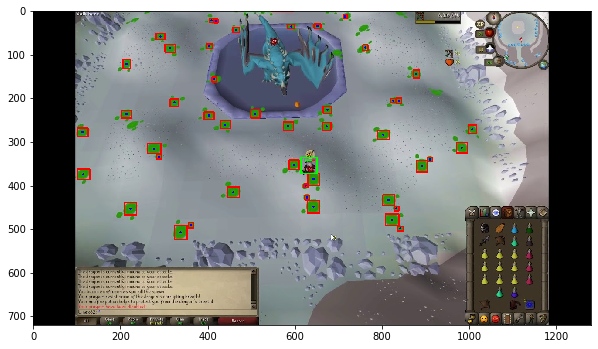

In [271]:
im2 = img.copy()
sq_width = 37
sp = (614, 335, sq_width, sq_width)
cv2.rectangle(im2, (sp[0],sp[1]), (sp[0]+sp[2], sp[1]+sp[3]), (0,255,0), 2)
show_pic(im2)

In [284]:
def check_collision(rects, rect2):
    for rect1 in rects:
        if(rect1[0] < rect2[0] + rect2[2] and rect1[0] + rect1[2] > rect2[0] 
            and rect1[1] < rect2[1] + rect2[3] and rect1[1] + rect1[3] > rect2[1]):
            return True
    return False

def get_open_tile(positions, rect):
    tiles = {
        "right": (rect[0] + sq_width, rect[1], rect[2], rect[3]),
        "left":(rect[0] - sq_width, rect[1], rect[2], rect[3]),
        "down": (rect[0], rect[1]+sq_width, rect[2], rect[3]),
        "up":(rect[0], rect[1]-sq_width, rect[2], rect[3])
    }
    for d,p in tiles.items():
        if not check_collision(positions, p):
            return p
        else:
            print("Cannot move " + d)
            
def get_longest_path(positions, rect, limits={"xMin": 0, "xMax": 1000, "yMin": 0, "yMax": 520}, deny=[], threshold=4):    
    tiles = [
        {"key": "right", "pos": [rect[0] + sq_width, rect[1], rect[2], rect[3]], "posIdx": 0, "count": 0, "inc": sq_width},
        {"key": "left", "pos": [rect[0] - sq_width, rect[1], rect[2], rect[3]], "posIdx":0, "count": 0, "inc": -sq_width},
        {"key": "down", "pos": [rect[0], rect[1]+sq_width, rect[2], rect[3]], "posIdx": 1, "count": 0, "inc": sq_width},
        {"key": "up", "pos": [rect[0], rect[1]-sq_width, rect[2], rect[3]], "posIdx": 1, "count": 0, "inc": -sq_width}  
    ]                        
    
    for tile in tiles:
        if tile["key"] in deny:
            continue
            
        limit = 10   
        tile_open = not check_collision(positions, tile["pos"])
        while tile_open and limit > 0:            
            pos = tile["pos"][:]
            pos[tile["posIdx"]] += tile["inc"]
            
            if pos[0] < limits["xMax"] and pos[0] > limits["xMin"] and pos[1] < limits["yMax"] and pos[1] > limits["yMin"]:            
                tile_open = not check_collision(positions, pos)
            else:
                tile_open = False
            
            if tile_open:
                tile["count"] += 1
                tile["pos"] = pos
                
            if tile["count"] >= threshold:
                return tile["pos"]
            
            limit -= 1
            
    tiles = sorted(tiles, key=lambda x: x["count"])
    print(tiles)
    return tiles[-1]["pos"]
    
    

def draw_rect(img, rect):
    img = cv2.rectangle(img, (rect[0],rect[1]), (rect[0]+rect[2], rect[1]+rect[3]), (255,150,0), 2)
    return img

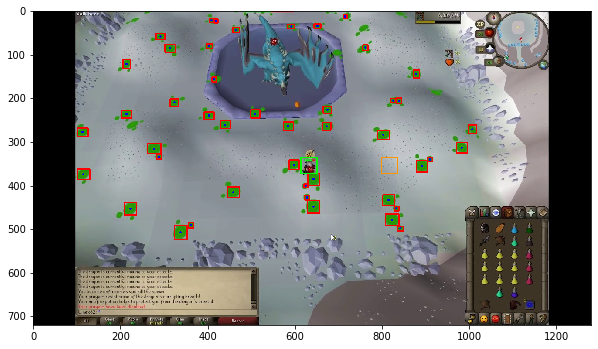

In [285]:
im_move = im2.copy()
pos = get_longest_path(positions, sp, deny=["up"])
im_move = draw_rect(im_move, pos)
show_pic(im_move)

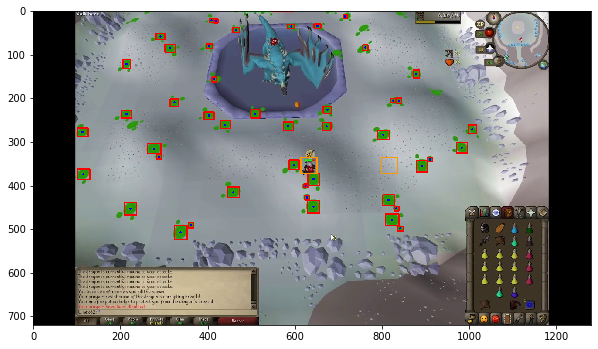

In [286]:
pos = get_longest_path(positions, pos)
im_move = draw_rect(im_move, pos)
show_pic(im_move)

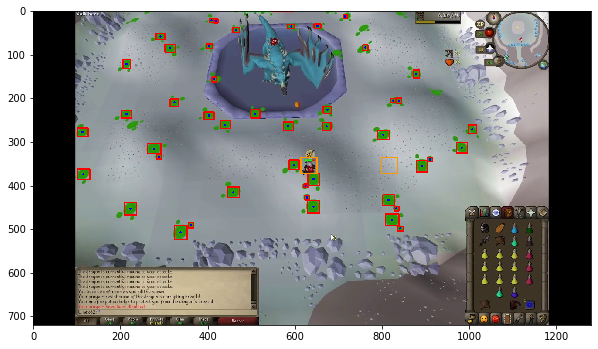

In [287]:
pos = get_longest_path(positions, pos)
im_move = draw_rect(im_move, pos)
show_pic(im_move)

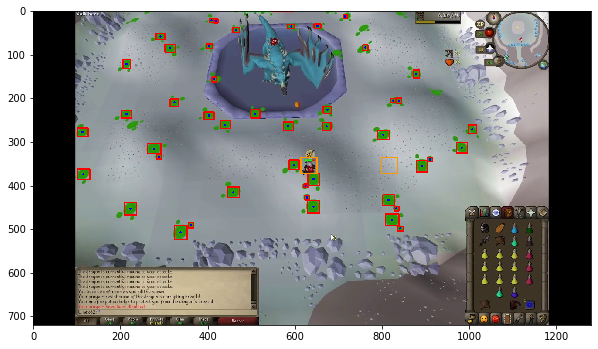

In [288]:
pos = get_longest_path(positions, pos)
im_move = draw_rect(im_move, pos)
show_pic(im_move)

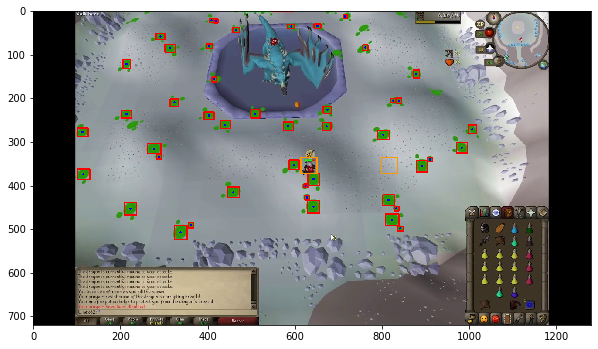

In [289]:
pos = get_longest_path(positions, pos)
im_move = draw_rect(im_move, pos)
show_pic(im_move)